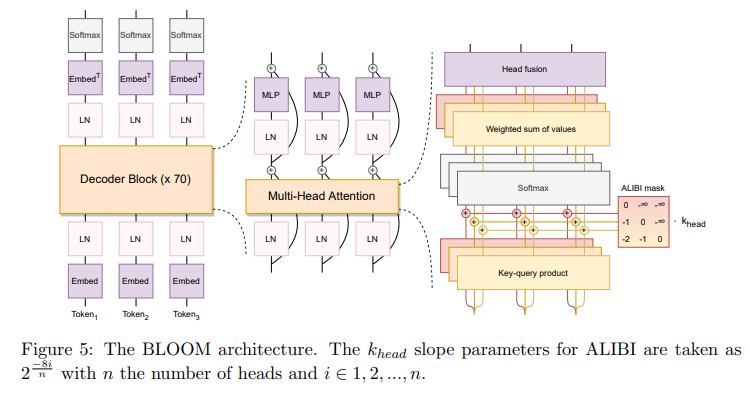

In [15]:
import math
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import torch.nn.functional as F


In [16]:
with open('/content/multilang_dataset.txt', 'r', encoding='utf-8') as f:
    z = f.read()

tokenizer(BPE)

In [17]:
import re
from collections import defaultdict, Counter

class BPE:
    def __init__(self, vocab_size=100):
        self.vocab_size = vocab_size
        self.bpe_codes = {}
        self.bpe_vocab = {}

    def get_stats(self, corpus):
        """Подсчитать частоты пар символов"""
        pairs = defaultdict(int)
        for word, freq in corpus.items():
            symbols = word.split()
            for i in range(len(symbols) - 1):
                pair = (symbols[i], symbols[i+1])
                pairs[pair] += freq
        return pairs

    def merge_vocab(self, pair, corpus):
        """Слить самую частую пару в новую подстроку"""
        pattern = re.escape(' '.join(pair))
        replacement = ''.join(pair)
        new_corpus = {}
        for word in corpus:
            new_word = re.sub(pattern, replacement, word)
            new_corpus[new_word] = corpus[word]
        return new_corpus

    def fit(self, words):
        """Обучение BPE кодов"""
        corpus = Counter([' '.join(list(w)) + ' </w>' for w in words])  # слово как символы + end token
        self.bpe_vocab = dict(corpus)

        for i in range(self.vocab_size):
            pairs = self.get_stats(self.bpe_vocab)
            if not pairs:
                break
            best = max(pairs, key=pairs.get)
            self.bpe_codes[best] = i
            self.bpe_vocab = self.merge_vocab(best, self.bpe_vocab)

    def encode_word(self, word):
        """Разбить слово на BPE-токены"""
        word = list(word) + ['</w>']
        while True:
            pairs = [(word[i], word[i+1]) for i in range(len(word)-1)]
            if not pairs:
                break

            mergeable = {pair: self.bpe_codes[pair] for pair in pairs if pair in self.bpe_codes}
            if not mergeable:
                break

            best_pair = min(mergeable, key=mergeable.get)
            new_word = []
            i = 0
            while i < len(word):
                if i < len(word) - 1 and (word[i], word[i+1]) == best_pair:
                    new_word.append(word[i] + word[i+1])
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            word = new_word
        return word

    def encode(self, text):
        """Токенизировать весь текст"""
        return [self.encode_word(word) for word in text.split()]


In [18]:
corpus =z.split()
print(corpus)

['i', 'cannot', 'see', 'where', 'the', 'green', 'arrow', 'is', 'pointing', '.', 'a', 'woman', 'is', 'pointing', 'at', 'the', 'camera', 'while', 'lying', 'down', 'a', 'finger', 'pointing', 'at', 'a', 'hotdog', 'with', 'cheese', ',', 'sauerkraut', 'and', 'ketchup', '.', 'a', 'very', 'crowded', 'street', 'sign', 'pointing', 'to', 'attractions', 'in', 'multiple', 'directions', 'several', 'people', 'are', 'on', 'a', 'beach', 'with', 'surf', 'boards', 'and', 'two', 'of', 'the', 'guys', 'are', 'pointing', 'toward', 'the', 'water', '.', 'a', 'man', 'wearing', 'glasses', 'and', 'a', 'suit', 'points', 'the', 'finger', 'as', 'he', 'speaks', 'a', 'couple', 'of', 'wood', 'signs', 'pointed', 'in', 'different', 'directions', 'a', 'person', 'holding', 'a', 'remote', 'control', 'pointed', 'at', 'a', 'television', '.', 'a', 'wake', 'boarder', 'pointing', 'at', 'a', 'wave', 'breaking', 'on', 'the', 'shore', '.', 'a', 'hand', 'points', 'a', 'black', 'and', 'white', 'remote', 'toward', 'a', 'large', 'scree

In [19]:
bpe = BPE(vocab_size=50)
bpe.fit(corpus)

In [20]:
text = 'cannot see'
tokenized = bpe.encode(text)

# Печать результата
for word, tokens in zip(text.split(), tokenized):
    print(f"{word} -> {tokens}")

cannot -> ['c', 'an', 'n', 'o', 't</w>']
see -> ['s', 'e', 'e</w>']


GELU

In [21]:
def tanh(x):
  y = (math.exp(x)-math.exp(-x))/(math.exp(x)+math.exp(-x))
  return y

In [22]:
class gelu(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    y = (0.5*x)*(1 + tanh(math.sqrt(2)/math.pi*(x+0.044715*(x**3))))
    return y

RMSnorm

In [23]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))  # обучаемый вектор масштаба

    def forward(self, x):
        # x: [batch, seq_len, dim]
        # 1. Вычисляем среднеквадратичную норму по последней размерности
        rms = torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)  # [B, T, 1]

        # 2. Делим x на RMS
        x_normed = x / rms

        # 3. Масштабируем обучаемым параметром scale
        return x_normed * self.scale  # [B, T, dim]

BLOOM

In [24]:

class mask_MHA(nn.Module):
  def __init__(self,heads,d_embed):
    super().__init__()
    self.heads = heads
    self.d_embed = d_embed
    self.d_k = d_embed // heads
    self.Wq = nn.Linear(d_embed,d_embed)
    self.Wk = nn.Linear(d_embed,d_embed)
    self.Wv = nn.Linear(d_embed,d_embed)
    self.Wa = nn.Linear(d_embed,d_embed)
  def forward(self,Q,K,V):
    batch_size = Q.size(0)
    Q = self.Wq(Q).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
    K = self.Wk(K).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)
    V = self.Wv(V).view(batch_size, -1, self.heads, self.d_k).transpose(1, 2)

    scor = torch.matmul(Q,K.transpose(-2,-1)/torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32)))
    mask = torch.triu(torch.ones_like(scor), diagonal=1).bool()

    # Заменяем элементы выше диагонали на -inf
    scor.masked_fill_(mask, float('-inf'))
    A = F.softmax(scor,dim = -1)
    output = torch.matmul(A,V)
    output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_embed)
    return self.Wa(output)


In [25]:
class Feed_forward(nn.Module):
  def __init__(self,n_embed):
    super().__init__()
    self.l1 = nn.Linear(n_embed,4*n_embed)
    self.l2 = gelu()
    self.l3 = nn.Linear(4*n_embed,n_embed)
  def forward(self,x):
    l1 = self.l1(x)
    l2 = self.l2(l1)
    l3 = self.l3(l2)
    return l3


In [29]:
class BLOOM_block(nn.Module):
  def __init__(self):
    super().__init__()
    self.rmsnorm = RMSNorm(1)
    self.ff = Feed_forward(100)
    self.mha = mask_MHA(4,100)
  def forward(self,x):
    l1 = self.rmsnorm(x)
    l2 = self.mha(l1)
    l3 = l1 + l2
    l4 = self.rmsnorm(l3)
    l5 = self.ff(l4)
    return l5

In [27]:
def train(model, data, optimizer, criterion, epochs=1000, batch_size=32, block_size=32, device='cpu'):
    model.train()
    count  = 0
    for epoch in range(epochs):
        total_loss = 0
        for _ in range(len(data) // batch_size):
            ix = torch.randint(0, len(data) - block_size - 1, (batch_size,), device=device)
            block_size = 32
            x = torch.stack([data[i:i + block_size] for i in ix])           # shape [block_size]
            y = torch.stack([data[i + 1:i + block_size + 1] for i in ix]).unsqueeze(0)
           # print('y',y)
            optimizer.zero_grad()
            logits = model(x)
            """print("Logits shape:", logits.shape)
            print("Y shape:", y.shape)
            print("Logits view:", logits.view(-1, logits.size(-1)).shape)
            print("Y view:", y.view(-1).shape)"""
            #print('log',logits)
            #y = y.view(1)
            y = y[:, :, 0]
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            count += 1
         #   print(count)
            if count > 1500:
              break

        avg_loss = total_loss / (len(data) // batch_size)

        print(f"Epoch {epoch+1}: loss={avg_loss:.4f}")

In [30]:
model = BLOOM_block()

In [38]:
def tokenize_text_bpe(bpe_tokenizer, text, token2idx):
    """
    Токенизирует текст и превращает в 1D тензор индексов.
    """
    tokenized = bpe_tokenizer.encode(text)
    flat_tokens = [token for word in tokenized for token in word]
    token_ids = [token2idx[tok] for tok in flat_tokens if tok in token2idx]
    return torch.tensor(token_ids, dtype=torch.long)


In [39]:
def train_bpe_tokenizer(text, vocab_size=100):
    """
    Обучает BPE токенизатор на заданном тексте.
    text: str — текстовый корпус
    vocab_size: int — число итераций объединения (размер BPE словаря)

    return: обученный BPE токенизатор
    """
    words = text.strip().split()
    bpe = BPE(vocab_size=vocab_size)
    bpe.fit(words)
    return bpe


In [40]:
bpe = train_bpe_tokenizer(z, vocab_size=100)

In [42]:
from itertools import chain
device = 'cpu'
tokens = list(chain(*bpe.bpe_vocab.keys()))
unique_tokens = sorted(set(tokens))
token2idx = {tok: i for i, tok in enumerate(unique_tokens)}

# 4. Токенизируем текст
data = tokenize_text_bpe(bpe, text, token2idx).to(device)

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [46]:
def train(model, data, optimizer, criterion, epochs=1000, batch_size=32, block_size=32, device='cpu'):
    model.train()
    count = 0
    for epoch in range(epochs):
        total_loss = 0
        for _ in range(len(data) // batch_size):
            ix = torch.randint(0, len(data) - block_size - 1, (batch_size,), device=device)
            x = torch.stack([data[i:i + block_size] for i in ix])  # [B, T]
            y = torch.stack([data[i + 1:i + block_size + 1] for i in ix])  # [B, T]

            optimizer.zero_grad()
            logits = model(x)  # [B, T, vocab_size]

            # Сопоставим предсказания и таргеты
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            count += 1
            if count > 1500:
                break

       # avg_loss = total_loss / (len(data) // batch_size)
        print(f"Epoch {epoch + 1}: loss={total_loss:.4f}")


In [55]:
train(model, data, optimizer, criterion, epochs=10)

Epoch 1: loss=0.0000
Epoch 2: loss=0.0000
Epoch 3: loss=0.0000
Epoch 4: loss=0.0000
Epoch 5: loss=0.0000
Epoch 6: loss=0.0000
Epoch 7: loss=0.0000
Epoch 8: loss=0.0000
Epoch 9: loss=0.0000
Epoch 10: loss=0.0000


In [57]:

def chat(model, data, prompt, max_new_tokens=50, device='cpu'):
    model.eval()
    #input_ids = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=device)

    with torch.no_grad():
        output_ids = model.generate(data, max_new_tokens=max_new_tokens)

    output_text = tokenizer.decode(output_ids[0].tolist())
    return output_text

In [ ]:
prompt = "Before we processed"
response = chat(model, tokenizer, prompt, max_new_tokens=100)
print(response)